In [1]:
# Import 
import os
import numpy as np
from scipy.spatial import ConvexHull
from scipy.optimize import linear_sum_assignment
from itertools import permutations
import time
import pandas as pd
from joblib import dump, load
from pathlib import Path

## sourceXray
from src.sourceXray_BJ import sourceXray, compute_C, solve_H_right_inverse
from src.utils import *

## X-RAY
from src.XRAY import xray_BJ

## W 
import pysptools.abundance_maps as amp
nnls = amp.NNLS() # nonnegative constrained least squares and then row-normalize

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
obj = load("data/CB_10locs_complete_nonegpm25mpm1.joblib")
df = obj["df"]
Y = obj["Y"]
ys = ['pm1', 'pm25mpm1', 'pm10mpm25', 'tspmpm10', 'bc', 'co', 'no', 'no2']
col_label = ["PM1", "PM2.5-PM1", "PM10-PM2.5", "TSP-PM10", "BC", "CO", "NO", "NO2"]
b = pd.to_numeric(df['bulldozer'], errors='coerce')
d = pd.to_numeric(df['downwind'],  errors='coerce')
df['bulldozerxdownwind'] = (b*d).astype('Int8')

In [7]:
# Bootstrap results
outdir = Path("results/CB")
outdir.mkdir(parents=True, exist_ok=True)
n_reps = 100

# Data dimension
K = 3
n, J = Y.shape
groups = [0, 1] # ignore NA
G = len(groups)
q_levels = np.array([0, 0.1, 0.3, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 0.975, 0.99, 1], dtype=float)  
Q = len(q_levels)

In [8]:
# Save results
results_boots = {
    "time_sourceXray": np.full(n_reps, np.nan, dtype=float),
    "time_xray":       np.full(n_reps, np.nan, dtype=float),
    "logvol_sourceXray": np.full(n_reps, np.nan, dtype=float),
    
    "mu_tilde_hat_sourceXray": np.empty((n_reps, K), dtype=float),
    "C_hat_sourceXray": np.empty((n_reps, J, K), dtype=float),
    "C_hat_xray":       np.empty((n_reps, J, K), dtype=float),

    # quantiles
    "W_tilde_qbybulldozer_sourceXray": np.full((n_reps, G, Q, K), np.nan, float),
    "W_tilde_qbydownwind_sourceXray":  np.full((n_reps, G, Q, K), np.nan, float),
    "W_tilde_qbyinteraction_sourceXray": np.full((n_reps, G, Q, K), np.nan, float),
    "W_tilde_qby20230203to0204_sourceXray": np.full((n_reps, G, Q, K), np.nan, float),
    
    "W_tilde_qbybulldozer_xray": np.full((n_reps, G, Q, K), np.nan, float),
    "W_tilde_qbydownwind_xray":  np.full((n_reps, G, Q, K), np.nan, float),
    "W_tilde_qbyinteraction_xray": np.full((n_reps, G, Q, K), np.nan, float),
}

win1_start = pd.Timestamp('2023-02-02 11:30', tz='America/New_York')
win1_end   = pd.Timestamp('2023-02-02 14:45', tz='America/New_York')
win2_start = pd.Timestamp('2023-02-03 11:30', tz='America/New_York')
win2_end   = pd.Timestamp('2023-02-03 14:45', tz='America/New_York')
win3_start = pd.Timestamp('2023-02-04 11:30', tz='America/New_York')
win3_end   = pd.Timestamp('2023-02-04 14:45', tz='America/New_York')

for rep in range(n_reps):
    results = load(outdir/f"Bootstrap/CB_nonegpm25mpm1_K3_90th_bootstrap_rep{rep+1}.joblib")  

    seed_rep = results["seed"]
    rng = np.random.default_rng(seed_rep)

    # Collect results
    results_boots["time_sourceXray"][rep] = results["time_sourceXray"]
    results_boots["time_xray"][rep]       = results["time_xray"]
    results_boots["logvol_sourceXray"][rep] = results["logvol_sourceXray"]

    results_boots["mu_tilde_hat_sourceXray"][rep] = results["mu_tilde_hat_sourceXray"] # (K,)
    results_boots["C_hat_sourceXray"][rep] = results["C_hat_sourceXray"]  # (J,K)
    results_boots["C_hat_xray"][rep]       = results["C_hat_xray"]        # (J,K)

    results_boots["W_tilde_qbybulldozer_sourceXray"][rep] = results["W_tilde_qbybulldozer_sourceXray"]  # (G,Q,K)
    results_boots["W_tilde_qbydownwind_sourceXray"][rep]  = results["W_tilde_qbydownwind_sourceXray"]
    results_boots["W_tilde_qbyinteraction_sourceXray"][rep] = results["W_tilde_qbyinteraction_sourceXray"]

    results_boots["W_tilde_qbybulldozer_xray"][rep] = results["W_tilde_qbybulldozer_xray"]
    results_boots["W_tilde_qbydownwind_xray"][rep]  = results["W_tilde_qbydownwind_xray"]
    results_boots["W_tilde_qbyinteraction_xray"][rep] = results["W_tilde_qbyinteraction_xray"]
    
    # W
    ## resample
    idx = rng.integers(0, n, size=n)
    Yb = np.asarray(Y)[idx] 
    rb = Yb.sum(axis=1, keepdims=True)
    Yb_star = Yb / rb
    df_b = df.iloc[idx].copy()           # bootstrap sample of the df

    ## compare Feb 3 to Feb 2 and 4
    in_win2 = (df_b['date_local'] >= win2_start) & (df_b['date_local'] <= win2_end)
    in_win13 = (
        df_b['date_local'].between(win1_start, win1_end, inclusive='both')
        | df_b['date_local'].between(win3_start, win3_end, inclusive='both')
    )
    cov_b_03_vs_0204 = pd.Series(np.where(in_win2, 1, np.where(in_win13, 0, np.nan)), index=df_b.index)

    ## call W
    W_star_hat, _, _ = solve_H_right_inverse(Yb_star, results["H_star_hat_sourceXray"])
    W_tilde_hat_perm = W_star_hat * rb
    
    ## quantiles of W tilde by covariates
    results_boots["W_tilde_qby20230203to0204_sourceXray"][rep] = quantiles_by_group(W_tilde_hat_perm, cov_b_03_vs_0204, q_levels)

dump(results_boots, outdir/"Bootstrap/CB_nonegpm25mpm1_K3_90th_100bootstraps.joblib")   

['results/CB/Bootstrap/CB_nonegpm25mpm1_K3_90th_100bootstraps.joblib']

In [9]:
results_boots = load(outdir/"Bootstrap/CB_nonegpm25mpm1_K3_90th_100bootstraps.joblib")

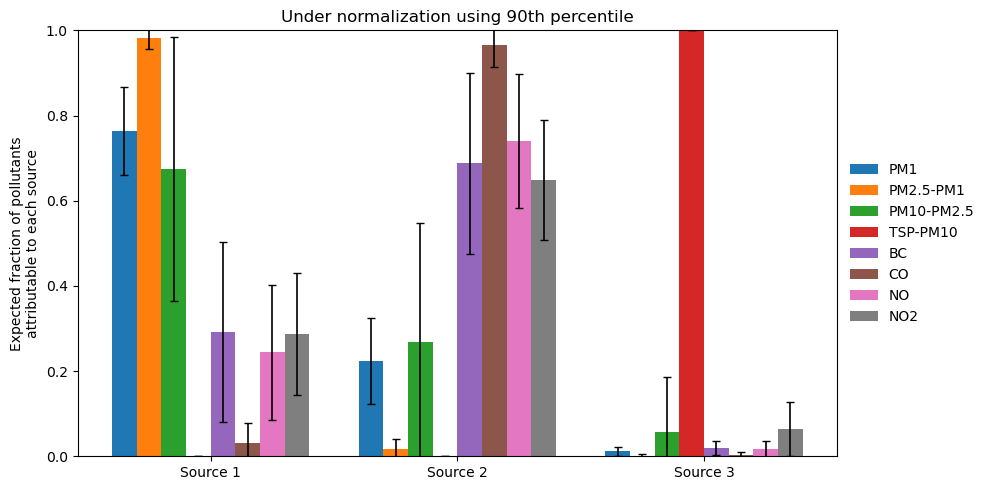

In [11]:
plot_C_matrix_grouped_by_k(
    results_boots["C_hat_sourceXray"], 
    title="Under normalization using 90th percentile",
    col_label=col_label, 
    savepath="results/CB/figure/CB_nonegpm25mpm1_sourceXray_K3_90th_bootstrap_Phi.pdf"
)

In [12]:
# Save results
results_boots2 = {
    "time_sourceXray": np.full(n_reps, np.nan, dtype=float),
    "time_xray":       np.full(n_reps, np.nan, dtype=float),
    "logvol_sourceXray": np.full(n_reps, np.nan, dtype=float),
    
    "mu_tilde_hat_sourceXray": np.empty((n_reps, K), dtype=float),
    "C_hat_sourceXray": np.empty((n_reps, J, K), dtype=float),
    "C_hat_xray":       np.empty((n_reps, J, K), dtype=float),

    # quantiles
    "W_tilde_qbybulldozer_sourceXray": np.full((n_reps, G, Q, K), np.nan, float),
    "W_tilde_qbydownwind_sourceXray":  np.full((n_reps, G, Q, K), np.nan, float),
    "W_tilde_qbyinteraction_sourceXray": np.full((n_reps, G, Q, K), np.nan, float),
    "W_tilde_qby20230203to0204_sourceXray": np.full((n_reps, G, Q, K), np.nan, float),
    
    "W_tilde_qbybulldozer_xray": np.full((n_reps, G, Q, K), np.nan, float),
    "W_tilde_qbydownwind_xray":  np.full((n_reps, G, Q, K), np.nan, float),
    "W_tilde_qbyinteraction_xray": np.full((n_reps, G, Q, K), np.nan, float),
}

win1_start = pd.Timestamp('2023-02-02 11:30', tz='America/New_York')
win1_end   = pd.Timestamp('2023-02-02 14:45', tz='America/New_York')
win2_start = pd.Timestamp('2023-02-03 11:30', tz='America/New_York')
win2_end   = pd.Timestamp('2023-02-03 14:45', tz='America/New_York')
win3_start = pd.Timestamp('2023-02-04 11:30', tz='America/New_York')
win3_end   = pd.Timestamp('2023-02-04 14:45', tz='America/New_York')

for rep in range(n_reps):
    results = load(outdir/f"Bootstrap/CB_nonegpm25mpm1_K3_95th_bootstrap_rep{rep+1}.joblib")  

    seed_rep = results["seed"]
    rng = np.random.default_rng(seed_rep)

    # Collect results
    results_boots2["time_sourceXray"][rep] = results["time_sourceXray"]
    results_boots2["time_xray"][rep]       = results["time_xray"]
    results_boots2["logvol_sourceXray"][rep] = results["logvol_sourceXray"]

    results_boots2["mu_tilde_hat_sourceXray"][rep] = results["mu_tilde_hat_sourceXray"] # (K,)
    results_boots2["C_hat_sourceXray"][rep] = results["C_hat_sourceXray"]  # (J,K)
    results_boots2["C_hat_xray"][rep]       = results["C_hat_xray"]        # (J,K)

    results_boots2["W_tilde_qbybulldozer_sourceXray"][rep] = results["W_tilde_qbybulldozer_sourceXray"]  # (G,Q,K)
    results_boots2["W_tilde_qbydownwind_sourceXray"][rep]  = results["W_tilde_qbydownwind_sourceXray"]
    results_boots2["W_tilde_qbyinteraction_sourceXray"][rep] = results["W_tilde_qbyinteraction_sourceXray"]

    results_boots2["W_tilde_qbybulldozer_xray"][rep] = results["W_tilde_qbybulldozer_xray"]
    results_boots2["W_tilde_qbydownwind_xray"][rep]  = results["W_tilde_qbydownwind_xray"]
    results_boots2["W_tilde_qbyinteraction_xray"][rep] = results["W_tilde_qbyinteraction_xray"]
    
    # W
    ## resample
    idx = rng.integers(0, n, size=n)
    Yb = np.asarray(Y)[idx] 
    rb = Yb.sum(axis=1, keepdims=True)
    Yb_star = Yb / rb
    df_b = df.iloc[idx].copy()           # bootstrap sample of the df

    ## compare Feb 3 to Feb 2 and 4
    in_win2 = (df_b['date_local'] >= win2_start) & (df_b['date_local'] <= win2_end)
    in_win13 = (
        df_b['date_local'].between(win1_start, win1_end, inclusive='both')
        | df_b['date_local'].between(win3_start, win3_end, inclusive='both')
    )
    cov_b_03_vs_0204 = pd.Series(np.where(in_win2, 1, np.where(in_win13, 0, np.nan)), index=df_b.index)

    ## call W
    W_star_hat, _, _ = solve_H_right_inverse(Yb_star, results["H_star_hat_sourceXray"])
    W_tilde_hat_perm = W_star_hat * rb
    
    ## quantiles of W tilde by covariates
    results_boots2["W_tilde_qby20230203to0204_sourceXray"][rep] = quantiles_by_group(W_tilde_hat_perm, cov_b_03_vs_0204, q_levels)

dump(results_boots2, outdir/"Bootstrap/CB_nonegpm25mpm1_K3_95th_100bootstraps.joblib")   

['results/CB/Bootstrap/CB_nonegpm25mpm1_K3_95th_100bootstraps.joblib']

In [13]:
results_boots2 = load(outdir/"Bootstrap/CB_nonegpm25mpm1_K3_95th_100bootstraps.joblib")

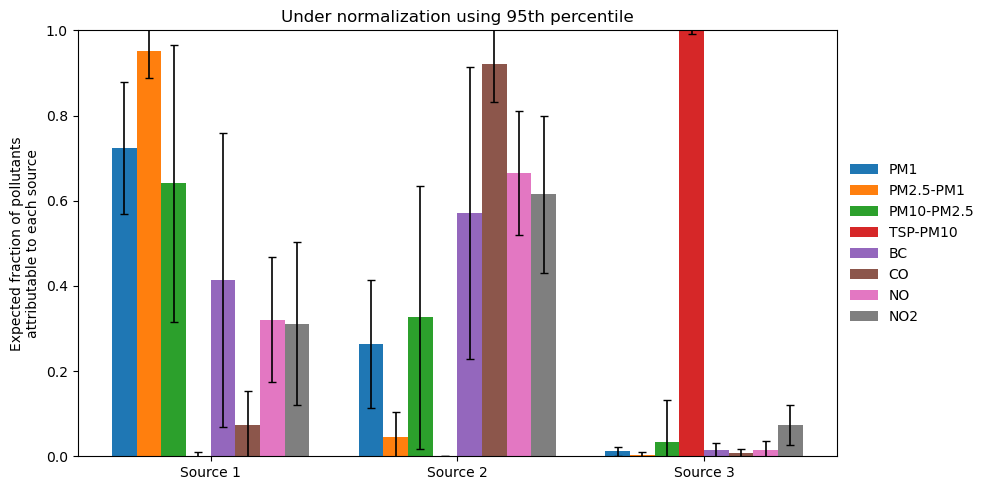

In [14]:
plot_C_matrix_grouped_by_k(
    results_boots2["C_hat_sourceXray"], 
    title="Under normalization using 95th percentile",
    col_label=col_label, 
    savepath="results/CB/figure/CB_nonegpm25mpm1_sourceXray_K3_95th_bootstrap_Phi.pdf"
)